In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray
import platform
import yaml
from tqdm import tqdm 
from pathlib import Path
from rasterio.warp import transform
from pyproj import Transformer
from ascat.read_native.ragged_array_ts import CellFileCollection
from ascat.cell import CellGridFiles
from dask.diagnostics import ProgressBar
from tqdm import tqdm
import pandas as pd


## Map Sentinel-1 and ASCAT

In [ ]:
def process_sentinel_and_ascat(sentinel_path, output_path, sentinel_crs):
    """
    Load Sentinel-1 Zarr file, assign EPSG, collocate with ASCAT data, and save to NetCDF.
    
    Parameters:
        zarr_path (str or Path): Path to Sentinel-1 Zarr file
        sentinel_epsg (str): EPSG code for Sentinel-1 data (e.g., "EPSG:27704")
        output_path (str): Path to save the resulting NetCDF file
    """
    print("Loading Sentinel-1 data...")
    sentinel_ds = xr.open_zarr(sentinel_path)
    sentinel_ds = sentinel_ds.rio.write_crs(sentinel_crs)

    sentinel_ds_latlon = sentinel_ds.rio.reproject("EPSG:4326")
    latmin = float(sentinel_ds_latlon.y.min())
    latmax = float(sentinel_ds_latlon.y.max())
    lonmin = float(sentinel_ds_latlon.x.min())
    lonmax = float(sentinel_ds_latlon.x.max())
    bbox = (latmin, latmax, lonmin, lonmax)
    print("Done")

    print("Loading ASCAT data...")
    paths = yaml.safe_load(Path("../paths.yml").read_text())
    system_key = "windows" if platform.system() == "Windows" else "linux"
    root = Path(paths[system_key]).expanduser()
    cell_source = root / "datasets/scat_ard/ascat_ssm_cdr_12.5km_h121"
    assert cell_source.exists(), f"ASCAT data path does not exist: {cell_source}"

    h121_reader = CellGridFiles.from_product_id(cell_source, "H121")
    ascat_ds = h121_reader.read(bbox=bbox)
    print("Done")

    print("Processing...")
    points_ds = ascat_ds.cf_geom.to_point_array()
    x, y = Transformer.from_crs("EPSG:4326", sentinel_crs, always_xy=True).transform(points_ds.lon, points_ds.lat)
    points_ds['e7x'] = ('obs', x)
    points_ds['e7y'] = ('obs', y)

    ascat_sentinel = sentinel_ds.sel(
        x=points_ds.e7x.load(),
        y=points_ds.e7y.load(),
        time=points_ds.time.load(),
        method="nearest"
    )

    ascat_ds['s1-VH'] = ("obs", ascat_sentinel['VH'].data)
    ascat_ds['s1-VV'] = ("obs", ascat_sentinel['VV'].data)
    print("Done")

    print(f"Saving output to {output_path}...")
    ascat_ds['subsurface_scattering_probability'].encoding.update({'dtype': 'float32'}) # Ensure correct dtype as NANs are a problem otherwise
    with ProgressBar():
        ascat_ds.to_netcdf(output_path)
    print(f"Done! Collocated dataset saved to {output_path}")


In [ ]:
# Europe
europe_files = [d for d in os.listdir("../data/Sentinel-1/Europe") if d.endswith(".zarr")]

for d in tqdm(europe_files, desc="Processing Europe"):
    sentinel_path = os.path.join("../data/Sentinel-1/Europe", d)
    output_path = os.path.join("../data/ASCAT_with_S1_values/Europe", 
                               "ASCAT_and_S1_" +  d.replace(".zarr", ""))
    
    print(f"Processing Europe: {sentinel_path} -> {output_path}")
    process_sentinel_and_ascat(
        sentinel_path=sentinel_path,
        output_path=output_path,
        sentinel_crs="EPSG:27704"
    )

# Africa
africa_files = [d for d in os.listdir("../data/Sentinel-1/Africa") if d.endswith(".zarr")]

for d in tqdm(africa_files, desc="Processing Africa"):
    sentinel_path = os.path.join("../data/Sentinel-1/Africa", d)
    output_path = os.path.join("../data/ASCAT_with_S1_values/Africa", 
                               "ASCAT_and_S1_" +  d.replace(".zarr", "")) # ending .nc necessary??
    
    print(f"Processing Africa: {sentinel_path} -> {output_path}")
    process_sentinel_and_ascat(
        sentinel_path=sentinel_path,
        output_path=output_path,
        sentinel_crs="EPSG:27701"
    )


## Checking the Results

In [5]:
import os
import pandas as pd
import xarray as xr

folders = [
    "../data/ASCAT_with_S1_values/Africa",
    "../data/ASCAT_with_S1_values/Europe"
]

summary = []

for folder in folders:
    for filename in os.listdir(folder):
        filepath = os.path.join(folder, filename)

        ds = xr.open_dataset(filepath)

        sizes = ds.sizes
        n_obs = sizes.get("obs", None)
        n_locations = sizes.get("locations", None)

        time_values = pd.to_datetime(ds["time"].values)

        n_timesteps = len(time_values)
        first_time = time_values[0]
        last_time = time_values[-1]

        month_periods = pd.Series(time_values).dt.to_period("M")
        month_counts = month_periods.value_counts()
        min_obs_per_month = month_counts.min() if not month_counts.empty else 0
        months_covered = month_counts.size

        summary.append([
            filepath, n_locations, n_obs, n_timesteps,
            first_time, last_time,
            min_obs_per_month, months_covered
        ])

df_summary = pd.DataFrame(summary, columns=[
    "path", "n_locations", "n_obs", "n_timesteps", "first_time", "last_time",
    "min_obs_per_month", "months_covered"
])

print(df_summary.to_string(index=False))


                                          path  n_locations    n_obs  n_timesteps                    first_time                     last_time  min_obs_per_month  months_covered
../data/ASCAT_with_S1_values/Africa/E036N090T3          450  6893094      6893094 2007-01-02 09:22:41.136000000 2024-12-31 19:55:39.770999808              14642             216
../data/ASCAT_with_S1_values/Africa/E036N087T3          642  9549903      9549903 2007-01-02 09:23:23.599999488 2024-12-31 19:55:06.648000000              20427             216
../data/ASCAT_with_S1_values/Africa/E033N090T3          311  4690330      4690330 2007-01-02 09:22:50.478000128 2024-12-31 20:53:03.255000064              10064             216
../data/ASCAT_with_S1_values/Africa/E030N087T3          660  9699615      9699615 2007-01-01 21:01:25.095000064 2024-12-31 21:35:16.260999680              20304             216
../data/ASCAT_with_S1_values/Africa/E033N087T3          657  9689217      9689217 2007-01-01 21:01:19.999000064 202

In [10]:
ds = xr.open_dataset("../data/ASCAT_with_S1_values/Africa/E030N087T3")
ds

<xarray.Dataset> Size: 543MB
Dimensions:                            (obs: 9699615, locations: 660)
Coordinates:
    time                               (obs) datetime64[ns] 78MB ...
    lon                                (locations) float32 3kB ...
    lat                                (locations) float32 3kB ...
    alt                                (locations) float32 3kB ...
Dimensions without coordinates: obs, locations
Data variables: (12/23)
    as_des_pass                        (obs) int8 10MB ...
    swath_indicator                    (obs) int8 10MB ...
    surface_flag                       (obs) uint8 10MB ...
    surface_soil_moisture              (obs) float32 39MB ...
    surface_soil_moisture_noise        (obs) float32 39MB ...
    backscatter40                      (obs) float32 39MB ...
    ...                                 ...
    sat_id                             (obs) int8 10MB ...
    row_size                           (locations) int64 5kB ...
    location_id                        (locations) int64 5kB ...
    location_description               (locations) <U1 3kB ...
    s1-VH                              (obs) float32 39MB ...
    s1-VV                              (obs) float32 39MB ...
Attributes:
    id:                 1248.nc
    date_created:       2025-01-09 12:35:09
    featureType:        timeSeries
    grid_mapping_name:  fibgrid_12.5

In [ ]:
loc_id = ds['location_id'].values[0]

subset = ds.where(ds['location_id'] == loc_id, drop=True)
subset

<xarray.Dataset> Size: 854MB
Dimensions:                            (obs: 9699615, locations: 1)
Coordinates:
    time                               (obs) datetime64[ns] 78MB ...
    lon                                (locations) float32 4B -5.196
    lat                                (locations) float32 4B 31.46
    alt                                (locations) float32 4B 9.969e+36
Dimensions without coordinates: obs, locations
Data variables: (12/23)
    as_des_pass                        (obs, locations) float32 39MB 0.0 ... 0.0
    swath_indicator                    (obs, locations) float32 39MB 0.0 ... 1.0
    surface_flag                       (obs, locations) float32 39MB 0.0 ... 0.0
    surface_soil_moisture              (obs, locations) float32 39MB 3.95 ......
    surface_soil_moisture_noise        (obs, locations) float32 39MB 9.57 ......
    backscatter40                      (obs, locations) float32 39MB -11.13 ....
    ...                                 ...
    sat_id                             (obs, locations) float32 39MB 3.0 ... 4.0
    row_size                           (locations) float64 8B 1.492e+04
    location_id                        (locations) float64 8B 8.569e+05
    location_description               (locations) object 8B ''
    s1-VH                              (obs, locations) float32 39MB -19.75 ....
    s1-VV                              (obs, locations) float32 39MB -10.69 ....
Attributes:
    id:                 1248.nc
    date_created:       2025-01-09 12:35:09
    featureType:        timeSeries
    grid_mapping_name:  fibgrid_12.5

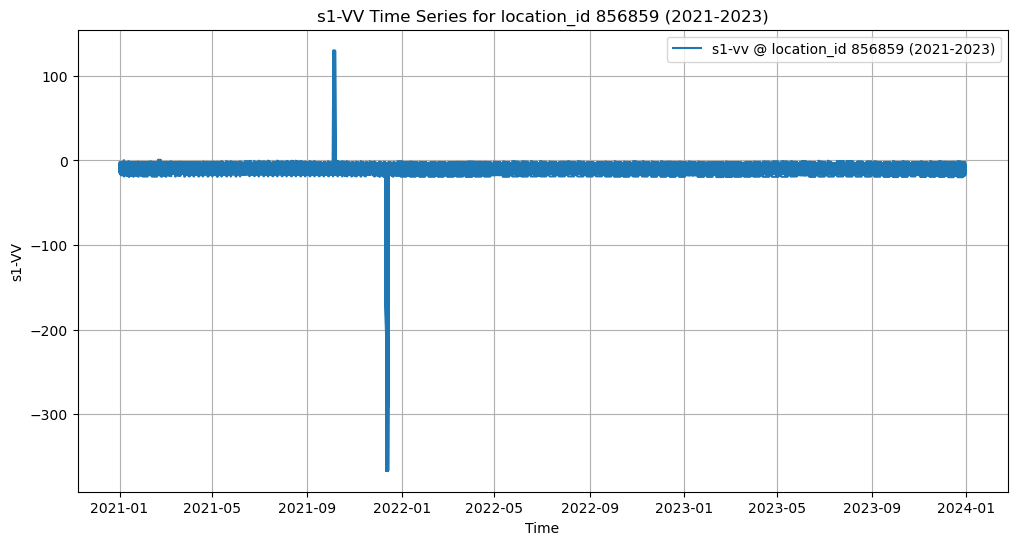

In [ ]:
time_index = pd.to_datetime(subset['time'].values)

mask = (time_index >= '2021-01-01') & (time_index <= '2023-12-31')

filtered_time = time_index[mask]
filtered_s1_VV = subset['s1-VV'].values[mask]

plt.figure(figsize=(12,6))
plt.plot(filtered_time, filtered_s1_VV, label=f's1-vv @ location_id {loc_id} (2021-2023)')
plt.xlabel('Time')
plt.ylabel('s1-VV')
plt.title(f's1-VV Time Series for location_id {loc_id} (2021-2023)')
plt.legend()
plt.grid(True)
plt.show()


loading two files simutaniously:

https://github.com/TUW-GEO/ascat/blob/master/src/ascat/cell.py#L341
    def _merge_contiguous(self, data):


## Testing the Workflow

### Loading Sentinel 1 data

In [8]:
sentinel_ds = xr.open_zarr("output_6km_filled.zarr")
sentinel_ds

<xarray.Dataset> Size: 11kB
Dimensions:  (time: 2, y: 26, x: 26)
Coordinates:
  * time     (time) datetime64[ns] 16B 2022-01-06T19:00:00 2022-01-07T07:00:00
  * x        (x) float64 208B 3.143e+06 3.15e+06 ... 3.293e+06 3.298e+06
  * y        (y) float64 208B 8.969e+05 8.906e+05 ... 7.346e+05 7.267e+05
Data variables:
    VH       (time, y, x) float32 5kB dask.array<chunksize=(1, 25, 25), meta=np.ndarray>
    VV       (time, y, x) float32 5kB dask.array<chunksize=(1, 25, 25), meta=np.ndarray>

In [11]:
# get bounds for ASCAT data from S1

# is this a good approach? look at step 1 to see why

sentinel_ds = sentinel_ds.rio.write_crs("EPSG:27704")

#bounds_proj = sentinel_ds.rio.bounds()

sentinel_ds_latlon = sentinel_ds.rio.reproject("EPSG:4326")

latmin = float(sentinel_ds_latlon.y.min())
latmax = float(sentinel_ds_latlon.y.max())
lonmin = float(sentinel_ds_latlon.x.min())
lonmax = float(sentinel_ds_latlon.x.max())

bbox=(latmin, latmax, lonmin, lonmax)

print(f"bbox: {bbox}")

bbox: (35.677603076219796, 37.581347591980396, -6.664028656833048, -4.420329763258051)


c:\Users\jwagner\AppData\Local\anaconda3\envs\ascat-s1-synergy\lib\site-packages\dask\array\chunk.py:279: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


We can see that we do not get the exact defined lat and lon we defined but a slightly bigger area. This should not be a problem in our further analysis.

### Reading ASCAT data points

In [12]:
# read yaml for reading data on Windows, Linux or the JupyterHub
paths = yaml.safe_load(Path("../paths.yml").read_text())
root = Path(paths["windows" if platform.system() == "Windows" else "linux"]).expanduser()
cell_source = root / "datasets/scat_ard/ascat_ssm_cdr_12.5km_h121"
assert cell_source.exists(), f"Path does not exist: {cell_source}"

Documentation from:
https://github.com/TUW-GEO/ascat/blob/master/docs/org/reading_cells.org

In [13]:
h121_reader = CellGridFiles.from_product_id(cell_source, "H121")

ascat_ds = h121_reader.read(bbox=bbox)
ascat_ds

<xarray.Dataset> Size: 219MB
Dimensions:                            (obs: 4206310, locations: 274)
Coordinates:
    time                               (obs) datetime64[ns] 34MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    lon                                (locations) float32 1kB dask.array<chunksize=(274,), meta=np.ndarray>
    lat                                (locations) float32 1kB dask.array<chunksize=(274,), meta=np.ndarray>
    alt                                (locations) float32 1kB dask.array<chunksize=(274,), meta=np.ndarray>
Dimensions without coordinates: obs, locations
Data variables: (12/21)
    as_des_pass                        (obs) int8 4MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    swath_indicator                    (obs) int8 4MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    surface_flag                       (obs) uint8 4MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    surface_soil_moisture              (obs) float32 17MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    surface_soil_moisture_noise        (obs) float32 17MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    backscatter40                      (obs) float32 17MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    ...                                 ...
    topographic_complexity             (obs) int8 4MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    subsurface_scattering_probability  (obs) float64 34MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    sat_id                             (obs) int8 4MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    row_size                           (locations) int64 2kB dask.array<chunksize=(274,), meta=np.ndarray>
    location_id                        (locations) int64 2kB dask.array<chunksize=(274,), meta=np.ndarray>
    location_description               (locations) <U1 1kB dask.array<chunksize=(274,), meta=np.ndarray>
Attributes:
    id:                 1249.nc
    date_created:       2025-01-09 12:30:17
    featureType:        timeSeries
    grid_mapping_name:  fibgrid_12.5

In [14]:
points_ds = ascat_ds.cf_geom.to_point_array()
points_ds

<xarray.Dataset> Size: 320MB
Dimensions:                            (obs: 4206310)
Coordinates:
    time                               (obs) datetime64[ns] 34MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    lon                                (obs) float32 17MB -6.244 ... -4.64
    lat                                (obs) float32 17MB 35.68 35.68 ... 37.55
    alt                                (obs) float32 17MB 9.969e+36 ... 9.969...
Dimensions without coordinates: obs
Data variables: (12/20)
    as_des_pass                        (obs) int8 4MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    swath_indicator                    (obs) int8 4MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    surface_flag                       (obs) uint8 4MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    surface_soil_moisture              (obs) float32 17MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    surface_soil_moisture_noise        (obs) float32 17MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    backscatter40                      (obs) float32 17MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    ...                                 ...
    wetland_fraction                   (obs) int8 4MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    topographic_complexity             (obs) int8 4MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    subsurface_scattering_probability  (obs) float64 34MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    sat_id                             (obs) int8 4MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    location_id                        (obs) int64 34MB 958101 ... 1001364
    location_description               (obs) <U1 17MB '' '' '' '' ... '' '' ''
Attributes:
    id:                 1249.nc
    date_created:       2025-01-09 12:30:17
    featureType:        point
    grid_mapping_name:  fibgrid_12.5

In [15]:
from pyproj import Transformer
x, y = Transformer.from_crs("EPSG:4326", "EPSG:27704", always_xy=True).transform(points_ds.lon, points_ds.lat)
x

array([3122906.75177061, 3122906.75177061, 3122906.75177061, ...,
       3331201.895713  , 3331201.895713  , 3331201.895713  ])

In [16]:
points_ds['e7x'] = ('obs', x)
points_ds['e7y'] = ('obs', y)

In [ ]:
points_ds

<xarray.Dataset> Size: 387MB
Dimensions:                            (obs: 4206310)
Coordinates:
    time                               (obs) datetime64[ns] 34MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    lon                                (obs) float32 17MB -6.244 ... -4.64
    lat                                (obs) float32 17MB 35.68 35.68 ... 37.55
    alt                                (obs) float32 17MB 9.969e+36 ... 9.969...
Dimensions without coordinates: obs
Data variables: (12/22)
    as_des_pass                        (obs) int8 4MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    swath_indicator                    (obs) int8 4MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    surface_flag                       (obs) uint8 4MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    surface_soil_moisture              (obs) float32 17MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    surface_soil_moisture_noise        (obs) float32 17MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    backscatter40                      (obs) float32 17MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    ...                                 ...
    subsurface_scattering_probability  (obs) float64 34MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    sat_id                             (obs) int8 4MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    location_id                        (obs) int64 34MB 958101 ... 1001364
    location_description               (obs) <U1 17MB '' '' '' '' ... '' '' ''
    e7x                                (obs) float64 34MB 3.123e+06 ... 3.331...
    e7y                                (obs) float64 34MB 7.377e+05 ... 8.804...
Attributes:
    id:                 1249.nc
    date_created:       2025-01-09 12:30:17
    featureType:        point
    grid_mapping_name:  fibgrid_12.5

In [ ]:
# testing the function

process_sentinel_and_ascat(
    sentinel_path="../data/Sentinel-1/Africa/E030N087T3.zarr",
    output_path="../data/ASCAT_with_S1_values/Africa/E030N087T3",
    sentinel_crs="EPSG:27701")

In [18]:
ascat_sentinel = sentinel_ds.sel(x=points_ds.e7x, y=points_ds.e7y, time=points_ds.time, method="nearest")
ascat_sentinel

<xarray.Dataset> Size: 185MB
Dimensions:      (obs: 4206310)
Coordinates:
    time         (obs) datetime64[ns] 34MB 2022-01-06T19:00:00 ... 2022-01-07...
    x            (obs) float64 34MB 3.143e+06 3.143e+06 ... 3.298e+06 3.298e+06
    y            (obs) float64 34MB 7.346e+05 7.346e+05 ... 8.782e+05 8.782e+05
    spatial_ref  int32 4B 0
    lon          (obs) float32 17MB -6.244 -6.244 -6.244 ... -4.64 -4.64 -4.64
    lat          (obs) float32 17MB 35.68 35.68 35.68 ... 37.55 37.55 37.55
    alt          (obs) float32 17MB 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
Dimensions without coordinates: obs
Data variables:
    VH           (obs) float32 17MB dask.array<chunksize=(625,), meta=np.ndarray>
    VV           (obs) float32 17MB dask.array<chunksize=(625,), meta=np.ndarray>

In [19]:
ascat_ds['s1-VH'] = ("obs", ascat_sentinel['VH'].data)
ascat_ds['s1-VV'] = ("obs", ascat_sentinel['VV'].data)
ascat_ds

<xarray.Dataset> Size: 252MB
Dimensions:                            (obs: 4206310, locations: 274)
Coordinates:
    time                               (obs) datetime64[ns] 34MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    lon                                (locations) float32 1kB dask.array<chunksize=(274,), meta=np.ndarray>
    lat                                (locations) float32 1kB dask.array<chunksize=(274,), meta=np.ndarray>
    alt                                (locations) float32 1kB dask.array<chunksize=(274,), meta=np.ndarray>
Dimensions without coordinates: obs, locations
Data variables: (12/23)
    as_des_pass                        (obs) int8 4MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    swath_indicator                    (obs) int8 4MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    surface_flag                       (obs) uint8 4MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    surface_soil_moisture              (obs) float32 17MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    surface_soil_moisture_noise        (obs) float32 17MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    backscatter40                      (obs) float32 17MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    ...                                 ...
    sat_id                             (obs) int8 4MB dask.array<chunksize=(1000000,), meta=np.ndarray>
    row_size                           (locations) int64 2kB dask.array<chunksize=(274,), meta=np.ndarray>
    location_id                        (locations) int64 2kB dask.array<chunksize=(274,), meta=np.ndarray>
    location_description               (locations) <U1 1kB dask.array<chunksize=(274,), meta=np.ndarray>
    s1-VH                              (obs) float32 17MB dask.array<chunksize=(625,), meta=np.ndarray>
    s1-VV                              (obs) float32 17MB dask.array<chunksize=(625,), meta=np.ndarray>
Attributes:
    id:                 1249.nc
    date_created:       2025-01-09 12:30:17
    featureType:        timeSeries
    grid_mapping_name:  fibgrid_12.5